In [1]:
import numpy as np
import pandas as pd
import datetime
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [2]:
df = pd.read_csv("m5-forecasting-accuracy/sales_train_validation.csv").sample(n=100, random_state=42)
df["id"] = df["item_id"] + "_" + df["store_id"]
df = df[["id", ] + [cn for cn in df.columns if cn.startswith("d_")]]

df = df.melt(id_vars="id", var_name="timestamp", value_name="value")
df["timestamp"] = pd.to_datetime(df["timestamp"].apply(
    lambda x: datetime.datetime(2011, 1, 28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

df["value"] = np.log1p(df["value"])

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="id",
    timestamp_column="timestamp"
)
train_data.head()

,,value
item_id,timestamp,
FOODS_3_180_CA_1,2011-01-29,0.000000
HOUSEHOLD_2_383_CA_3,2011-01-29,1.098612
FOODS_3_409_CA_3,2011-01-29,0.000000
FOODS_1_097_CA_2,2011-01-29,0.000000
HOBBIES_1_272_TX_2,2011-01-29,0.000000


In [3]:
predictor = TimeSeriesPredictor(
    prediction_length=28,
    path="autogluon-m5-daily",
    target="value",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/home/rsmith/PycharmProjects/time-series-llm/autogluon-m5-daily'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Dec 13 05:06:24 UTC 2025
CPU Count:          8
Pytorch Version:    2.7.1+cu118
CUDA Version:       11.8
GPU Memory:         GPU 0: 1.96/1.96 GB
Total GPU Memory:   Free: 1.96 GB, Allocated: 0.00 GB, Total: 1.96 GB
GPU Count:          1
Memory Avail:       7.11 GB / 15.47 GB (46.0%)
Disk Space Avail:   359.56 GB / 474.34 GB (75.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 'auto',
 'prediction_length': 28,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'ref

In [4]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-1.247168,8.738076,2.697032,10
1,TemporalFusionTransformer,-1.256316,0.285393,137.403261,8
2,Chronos2,-1.269141,6.586331,21.159099,5
3,ChronosWithRegressor[bolt_small],-1.281251,1.859593,2.575464,7
4,DeepAR,-1.325471,1.397919,139.458429,9
5,AutoETS,-1.519868,15.078873,18.570487,6
6,DynamicOptimizedTheta,-1.527021,14.805043,16.336141,4
7,DirectTabular,-1.672013,0.358931,3.800735,3
8,SeasonalNaive,-1.700856,0.143601,3.166223,1
9,RecursiveTabular,-1.706236,0.644955,57.141258,2


In [5]:
predictions = predictor.predict(train_data)
predictions[predictions < 0.0] = 0.0
predictions = np.expm1(predictions)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean  0.1       0.2       0.3       0.4  \
item_id            timestamp                                                 
FOODS_3_180_CA_1   2016-04-25  0.005344  0.0  0.003736  0.004788  0.002246   
                   2016-04-26  0.005923  0.0  0.003298  0.005309  0.002782   
                   2016-04-27  0.006409  0.0  0.003803  0.005183  0.002332   
                   2016-04-28  0.006886  0.0  0.003721  0.004351  0.001177   
                   2016-04-29  0.007341  0.0  0.003715  0.003446  0.000000   
...                                 ...  ...       ...       ...       ...   
HOBBIES_1_315_WI_1 2016-05-18  0.001703  0.0  0.000000  0.002758  0.002118   
                   2016-05-19  0.001856  0.0  0.000000  0.002513  0.001940   
                   2016-05-20  0.001909  0.0  0.000000  0.002600  0.001354   
                   2016-05-21  0.002473  0.0  0.000000  0.002892  0.000418   
                   2016-05-22  0.002949  0.0  0.000000  0.003606  0.000000   

                                    0.5       0.6       0.7       0.8  \
item_id            timestamp                                            
FOODS_3_180_CA_1   2016-04-25  0.005344  0.016400  0.170836  0.722678   
                   2016-04-26  0.005923  0.010874  0.161491  0.735286   
                   2016-04-27  0.006409  0.007350  0.160541  0.763331   
                   2016-04-28  0.006886  0.003794  0.167338  0.806711   
                   2016-04-29  0.007341  0.002063  0.184746  0.843927   
...                                 ...       ...       ...       ...   
HOBBIES_1_315_WI_1 2016-05-18  0.001703  0.007386  0.000000  0.149455   
                   2016-05-19  0.001856  0.006087  0.000000  0.156078   
                   2016-05-20  0.001909  0.004849  0.000000  0.170963   
                   2016-05-21  0.002473  0.005342  0.000398  0.194293   
                   2016-05-22  0.002949  0.007429  0.009568  0.226041   

                                    0.9  
item_id            timestamp             
FOODS_3_180_CA_1   2016-04-25  1.346535  
                   2016-04-26  1.333670  
                   2016-04-27  1.361228  
                   2016-04-28  1.395729  
                   2016-04-29  1.385893  
...                                 ...  
HOBBIES_1_315_WI_1 2016-05-18  0.941175  
                   2016-05-19  0.954775  
                   2016-05-20  0.964995  
                   2016-05-21  0.991736  
                   2016-05-22  1.005768  

[2800 rows x 10 columns]

In [6]:
test_df = pd.read_csv("m5-forecasting-accuracy/sales_train_evaluation.csv")
test_df["id"] = test_df["item_id"] + "_" + test_df["store_id"]
test_df = test_df[test_df["id"].isin(df["id"].unique())]
test_df = test_df[["id", ] + [cn for cn in test_df.columns if cn.startswith("d_")]]
test_df = test_df.melt(id_vars="id", var_name="timestamp", value_name="value")

test_df["timestamp"] = pd.to_datetime(test_df["timestamp"].apply(
    lambda x: datetime.datetime(2011, 1, 28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="id",
    timestamp_column="timestamp"
)
test_data

,,value
item_id,timestamp,
HOBBIES_1_100_CA_1,2011-01-29,1
HOBBIES_1_287_CA_1,2011-01-29,0
HOUSEHOLD_1_202_CA_1,2011-01-29,0
HOUSEHOLD_1_468_CA_1,2011-01-29,3
HOUSEHOLD_1_537_CA_1,2011-01-29,3
...,...,...
HOUSEHOLD_2_209_WI_3,2016-05-22,1
FOODS_2_127_WI_3,2016-05-22,0
FOODS_2_212_WI_3,2016-05-22,2


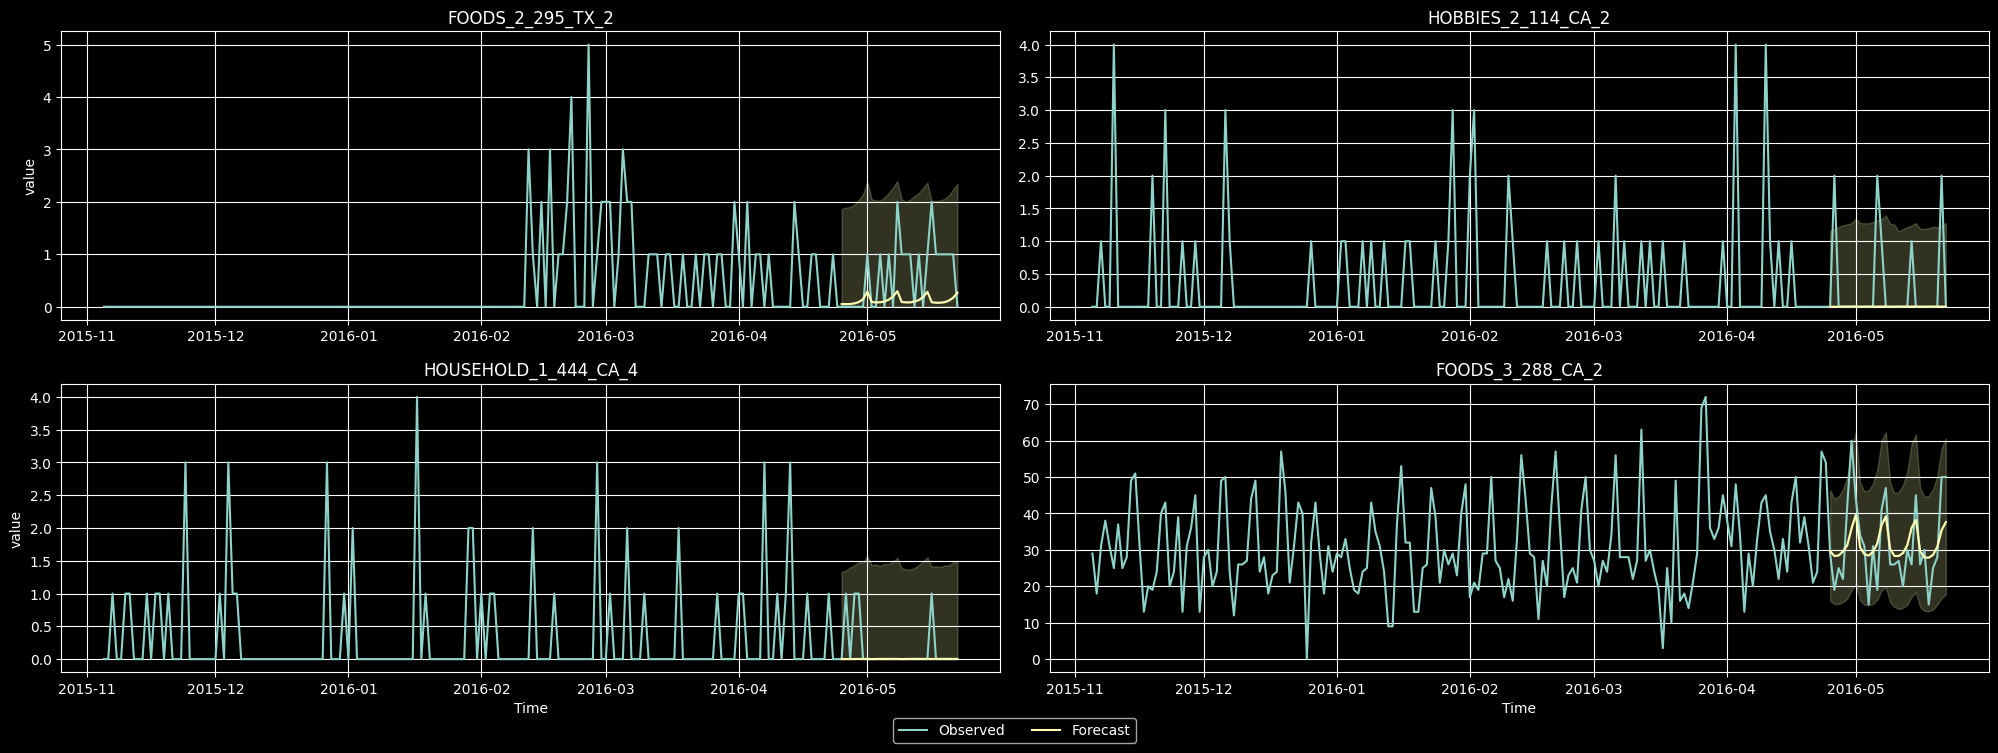

In [7]:
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4);